## Autoencoders

In [2]:
import torch
import torch.nn as nn

import numpy as np

from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

from src.model.models import Autoencoder, VAE, DBModelSmall
from src.data.datasets import ModelParamsDataset
from src.data.helpers import get_moons_dataset, get_accuracy, rotate

from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
autoencoder_mse = Autoencoder(33, 16, 0.2)
autoencoder_mse.load_state_dict(torch.load('../models/autoencoders/autoencoder_mseloss/model_final.pth'))
autoencoder_mse.eval()

autoencoder_dbloss = Autoencoder(33, 2, 0.2)
autoencoder_dbloss.load_state_dict(torch.load('../models/autoencoders/autoencoder_dbloss/model_final.pth'))
autoencoder_dbloss.eval()

vae_mseloss = VAE(33, 16, 0.2)
vae_mseloss.load_state_dict(torch.load('../models/autoencoders/vae_mseloss/model_kdl1.pth'))
vae_mseloss.eval()

vae_dbloss = VAE(33, 2, 0.2)
vae_dbloss.load_state_dict(torch.load('../models/autoencoders/vae_dbloss/model_kdl20.pth'))
vae_dbloss.eval()


VAE(
  (encoder): Sequential(
    (0): Linear(in_features=33, out_features=1024, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=128, out_features=2, bias=True)
  )
  (mu): Linear(in_features=2, out_features=2, bias=True)
  (logvar): 

In [5]:
dataset = ModelParamsDataset("../data/zoo_small.csv")
train_indices, test_indices, _, _ = train_test_split(range(len(dataset)), dataset.angles, stratify=dataset.angles, test_size=0.2, random_state=0)
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=False)

## Reconstruction accuracy

In [ ]:
trained_accuracies = []
autoencoder_mseloss_accuracies = []
autoencoder_dbloss_accuracies = []
vae_mseloss_accuracies = []
vae_dbloss_accuracies = []

model = DBModelSmall(batch_first=False)

X, y = get_moons_dataset()

for (parameter, angle) in tqdm(test_dataset):
    X_rotated = rotate(X, angle)
    X_rotated = torch.tensor(X_rotated).float().unsqueeze(0)

    model.set_weights(parameter)
    accuracy = get_accuracy(model, X_rotated, y)
    trained_accuracies.append(accuracy)

    reconstructed = autoencoder_mse(parameter.unsqueeze(0))
    reconstructed = reconstructed.squeeze()
    model.set_weights(reconstructed)
    accuracy = get_accuracy(model, X_rotated, y)
    autoencoder_mseloss_accuracies.append(accuracy)

    reconstructed = autoencoder_dbloss(parameter.unsqueeze(0))
    reconstructed = reconstructed.squeeze()
    model.set_weights(reconstructed)
    accuracy = get_accuracy(model, X_rotated, y)
    autoencoder_dbloss_accuracies.append(accuracy)

    reconstructed, _, _ = vae_mseloss(parameter.unsqueeze(0))
    reconstructed = reconstructed.squeeze()
    model.set_weights(reconstructed)
    accuracy = get_accuracy(model, X_rotated, y)
    vae_mseloss_accuracies.append(accuracy)

    reconstructed, _, _ = vae_dbloss(parameter.unsqueeze(0))
    reconstructed = reconstructed.squeeze()
    model.set_weights(reconstructed)
    accuracy = get_accuracy(model, X_rotated, y)
    vae_dbloss_accuracies.append(accuracy)

print(f"Mean trained accuracy: {np.mean(trained_accuracies)}")
print(f"Mean Autoencoder (MSELoss) accuracy: {np.mean(autoencoder_mseloss_accuracies)}")
print(f"Mean Autoencoder (DBLoss) accuracy: {np.mean(autoencoder_dbloss_accuracies)}")
print(f"Mean VAE (MSELoss) accuracy: {np.mean(vae_mseloss_accuracies)}")
print(f"Mean VAE (DBLoss) accuracy: {np.mean(vae_dbloss_accuracies)}")


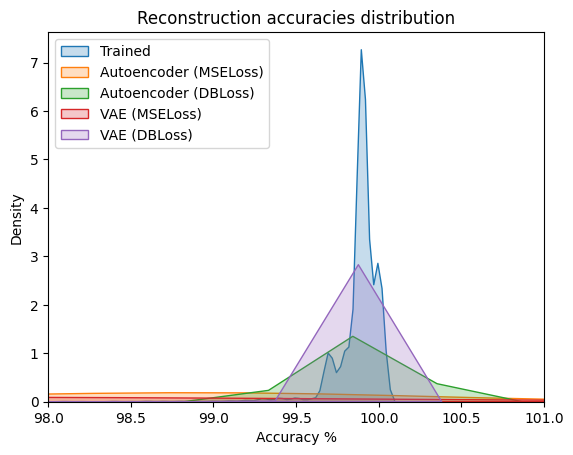

In [ ]:
sns.kdeplot(trained_accuracies, fill=True, label="Trained")
sns.kdeplot(autoencoder_mseloss_accuracies, fill=True, label="Autoencoder (MSELoss)")
sns.kdeplot(autoencoder_dbloss_accuracies, fill=True, label="Autoencoder (DBLoss)")
sns.kdeplot(vae_mseloss_accuracies, fill=True, label="VAE (MSELoss)")
sns.kdeplot(vae_dbloss_accuracies, fill=True, label="VAE (DBLoss)")

plt.legend(loc="upper left")
plt.title("Reconstruction accuracies distribution")
plt.xlabel("Accuracy %")
plt.xlim(98, 101)
plt.show()

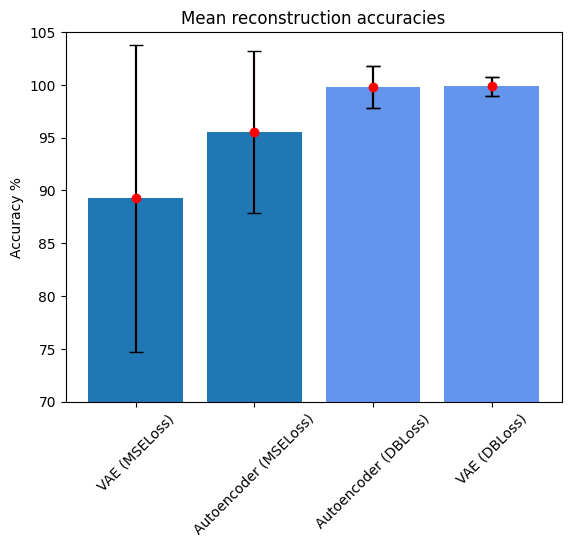

In [ ]:
autoencoder_mseloss_mean = np.mean(autoencoder_mseloss_accuracies)
autoencoder_dbloss_mean = np.mean(autoencoder_dbloss_accuracies)
vae_mseloss_mean = np.mean(vae_mseloss_accuracies)
vae_dbloss_mean = np.mean(vae_dbloss_accuracies)

autoencoder_mseloss_std = np.std(autoencoder_mseloss_accuracies)
autoencoder_dbloss_std = np.std(autoencoder_dbloss_accuracies)
vae_mseloss_std = np.std(vae_mseloss_accuracies)
vae_dbloss_std = np.std(vae_dbloss_accuracies)


x = np.array(["VAE (MSELoss)","Autoencoder (MSELoss)", "Autoencoder (DBLoss)", "VAE (DBLoss)"])
y = np.array([vae_mseloss_mean, autoencoder_mseloss_mean, autoencoder_dbloss_mean, vae_dbloss_mean])
e = np.array([vae_mseloss_std, autoencoder_mseloss_std, autoencoder_dbloss_std, vae_dbloss_std])

plt.errorbar(x, y, e, fmt="o", color="r")

# make these tick labels look good

# make bars thicker
plt.bar(x, y, yerr=e, capsize=5)


# color every second bar green
plt.bar(x[2], y[2], yerr=e[2], capsize=5, color="cornflowerblue")
plt.bar(x[3], y[3], yerr=e[3], capsize=5, color="cornflowerblue")

plt.ylim(70, 105)
plt.xticks(x, rotation=45)
plt.title("Mean reconstruction accuracies")
plt.ylabel("Accuracy %")
plt.show()

## Reconstruction distribution

In [ ]:
dataset = ModelParamsDataset("../data/zoo_small.csv")

original = []
autoencoder_mseloss_reconstructions = []
autoencoder_dbloss_reconstructions = []
vae_mseloss_reconstructions = []
vae_dbloss_reconstructions = []

for i in tqdm(range(10000)):
    parameter, angle = dataset[i]
    X_rotated = rotate(X, angle)
    X_rotated = torch.tensor(X_rotated).float().unsqueeze(0)

    original.append(parameter.squeeze().detach().numpy())

    reconstructed = autoencoder_mse(parameter.unsqueeze(0))
    autoencoder_mseloss_reconstructions.append(reconstructed.squeeze().detach().numpy())

    reconstructed = autoencoder_dbloss(parameter.unsqueeze(0))
    autoencoder_dbloss_reconstructions.append(reconstructed.squeeze().detach().numpy())

    reconstructed, _, _ = vae_mseloss(parameter.unsqueeze(0))
    vae_mseloss_reconstructions.append(reconstructed.squeeze().detach().numpy())

    reconstructed, _, _ = vae_dbloss(parameter.unsqueeze(0))
    vae_dbloss_reconstructions.append(reconstructed.squeeze().detach().numpy())

  0%|          | 0/10000 [00:00<?, ?it/s]

(33,)


  0%|          | 0/1000 [00:00<?, ?it/s]

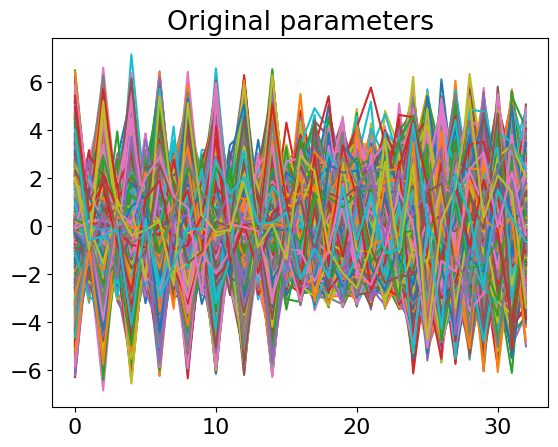

  0%|          | 0/1000 [00:00<?, ?it/s]

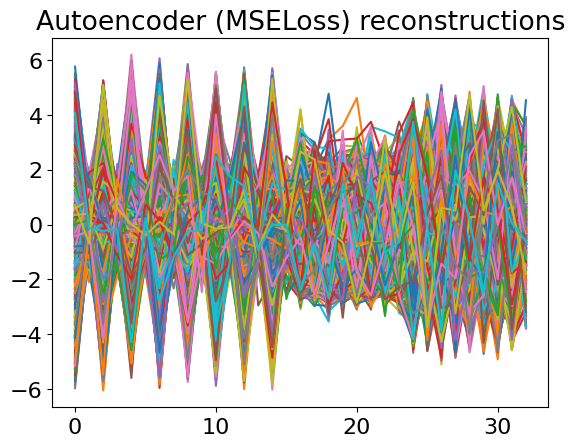

  0%|          | 0/1000 [00:00<?, ?it/s]

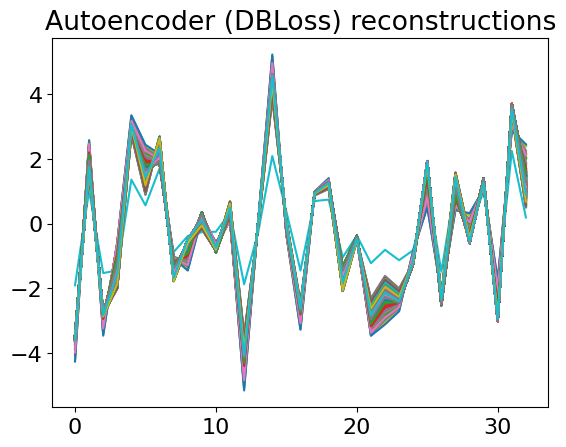

  0%|          | 0/1000 [00:00<?, ?it/s]

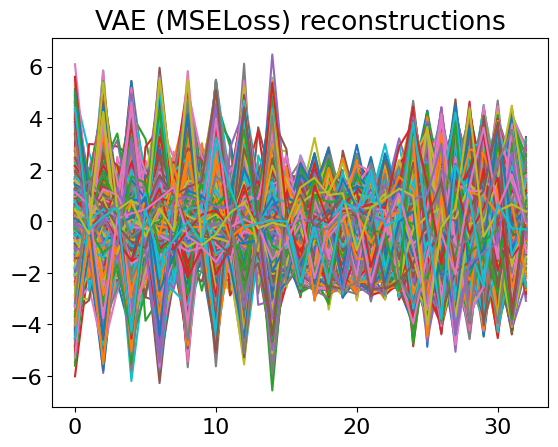

  0%|          | 0/1000 [00:00<?, ?it/s]

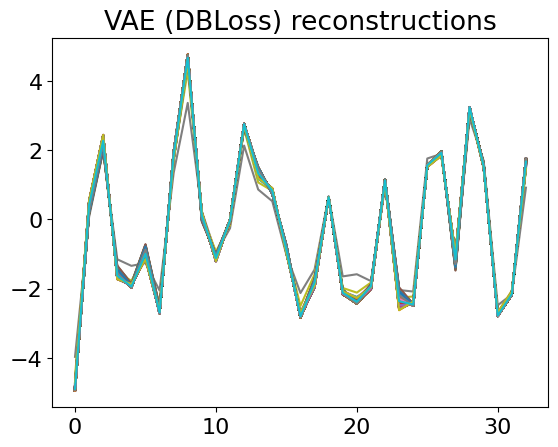

In [ ]:
x = list(range(33))

# Increase text size
plt.rcParams.update({'font.size': 16})

print(original[0].shape)

for i in tqdm(range(1000)):
    plt.plot(x, original[i], label="Original")

plt.title("Original parameters")
plt.show()

for i in tqdm(range(1000)):
    plt.plot(x, autoencoder_mseloss_reconstructions[i], label="Autoencoder (MSELoss)")

plt.title("Autoencoder (MSELoss) reconstructions")
plt.show()

for i in tqdm(range(1000)):
    plt.plot(x, autoencoder_dbloss_reconstructions[i], label="Autoencoder (DBLoss)")

plt.title("Autoencoder (DBLoss) reconstructions")
plt.show()

for i in tqdm(range(1000)):
    plt.plot(x, vae_mseloss_reconstructions[i], label="VAE (MSELoss)")

plt.title("VAE (MSELoss) reconstructions")
plt.show()

for i in tqdm(range(1000)):
    plt.plot(x, vae_dbloss_reconstructions[i], label="VAE (DBLoss)")

plt.title("VAE (DBLoss) reconstructions")
plt.show()

## Generators

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

import math

import numpy as np

from src.data.helpers import get_moons_dataset, rotate, get_accuracy, generate_diffusion, generate_flow
from src.model.models import Flow, Diffusion

from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\JetFire\AppData\Local\Temp\ipykernel_9696\2561270041.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(params, dtype=torch.float32)
C:\Users\JetFire\AppData\Local\Temp\ipykernel_9696\2561270041.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(params, dtype=torch.float32)
C:\Users\JetFire\AppData\Local\Temp\ipykernel_9696\2561270041.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(params, dtype=torch.float32)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Mean Flow accuracy: 91.99625
Mean Flow OT accuracy: 89.2325
Mean Diffusion accuracy: 94.319


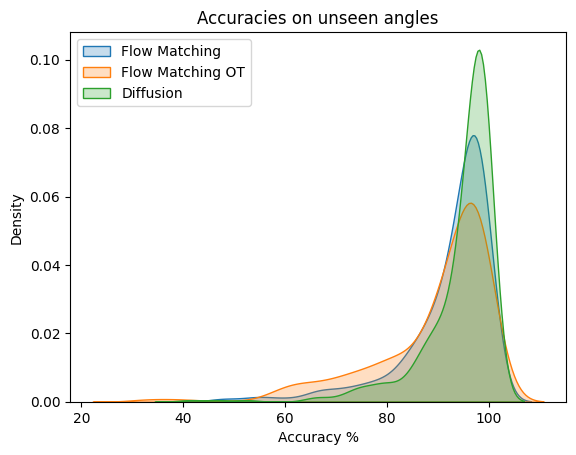

In [5]:
flow = Flow(hidden_dim = 512)
flow.load_state_dict(torch.load("../models/generators/flow_matching_small/flow_small_conditional.pth"))
flow.eval()

flow_ot = Flow(hidden_dim = 1024)
flow_ot.load_state_dict(torch.load("../models/generators/flow_matching_ot/flow_ot_conditional.pth"))
flow_ot.eval()

diffusion = Diffusion()
diffusion.load_state_dict(torch.load("../models/generators/diffusion/diffusion_conditional.pth"))
diffusion.eval()

gaussian = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(33), math.sqrt(1) * torch.eye(33))
betas = torch.tensor(np.linspace(1e-4, 0.02, 1000), dtype=torch.float32)

accuracies_flow = []
accuracies_flow_ot = []
accuracies_diffusion = []

model = DBModelSmall(batch_first=False)

angles = [45/2, 135/2, 225/2, 315/2, 405/2, 495/2, 585/2, 675/2]
X, y = get_moons_dataset()

with torch.no_grad():
    for angle in tqdm(angles):
        for i in tqdm(range(50)):

            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

            # Flow
            params = generate_flow(flow, angle)
            params = torch.tensor(params, dtype=torch.float32)

            model.set_weights(params)
            accuracy = get_accuracy(model, X_rotated, y)
            accuracies_flow.append(accuracy)

            # Flow OT
            params = generate_flow(flow_ot, angle)
            params = torch.tensor(params, dtype=torch.float32)

            model.set_weights(params)
            accuracy = get_accuracy(model, X_rotated, y)
            accuracies_flow_ot.append(accuracy)

            # Diffusion
            params = generate_diffusion(diffusion, angle, betas)
            params = torch.tensor(params, dtype=torch.float32)

            model.set_weights(params)
            accuracy = get_accuracy(model, X_rotated, y)
            accuracies_diffusion.append(accuracy)

    

print("Mean Flow accuracy:", np.mean(accuracies_flow))
print("Mean Flow OT accuracy:", np.mean(accuracies_flow_ot))
print("Mean Diffusion accuracy:", np.mean(accuracies_diffusion))

sns.kdeplot(accuracies_flow, fill=True, label="Flow Matching")
sns.kdeplot(accuracies_flow_ot, fill=True, label="Flow Matching OT")
sns.kdeplot(accuracies_diffusion, fill=True, label="Diffusion")
plt.title("Accuracies on unseen angles")
plt.xlabel("Accuracy %")
plt.legend(loc="upper left")
plt.show()